In [ ]:
# Imports

from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

## Training a model

In [ ]:
# Prelims
torch.manual_seed(42)

print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CUDA Available:  True


In [ ]:
# Defining the network

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [ ]:
# MNIST dataset and dataloader declaration

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,)),
            ])),
        batch_size=64, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,)),
            ])),
        batch_size=1, shuffle=True)


In [ ]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(model, device, data_loader, set_name="Test"):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(data_loader.dataset)

    print('{} set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        set_name,test_loss, correct, len(data_loader.dataset),
        100. * correct / len(data_loader.dataset)))
    return 100. * correct / len(data_loader.dataset)

In [ ]:
# Initialize, Train and Test the network
model = Net().to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)

test(model, device, test_loader)
for epoch in range(1, 2):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, train_loader, "Train")
    test(model, device, test_loader)

Test set: Average loss: 2.3129, Accuracy: 842/10000 (8%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.315993
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.204952
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.237592
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.225074
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.177442
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.299098
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.081390
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.183991
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.187173
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.098213
Train set: Average loss: 0.0442, Accuracy: 59198/60000 (99%)

Test set: Average loss: 0.0498, Accuracy: 9832/10000 (98%)



## FGSM Attack

### Untargeted

In [ ]:
def untargeted_fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon*sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

In [ ]:
def denormalize(batch, mean=0.1307, std=0.3081):
    mean = torch.tensor(mean)
    std = torch.tensor(std)
    batch = batch * std + mean
    return batch

In [ ]:
def test_untargeted_fgsm_attack(model, device, dataloader, epsilon=0.2):
     # Accuracy counter
    correct = 0
    total = 0
    adv_examples = []

    for data, label in dataloader:
        data, label = data.to(device), label.to(device)
        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True
        output = model(data)
        init_pred = output.argmax(1, keepdim=True) # get the index (predicted label)

        # If its already wrong, ignore the example
        if init_pred.item() != label.item():
            continue

        loss = F.cross_entropy(output, label)

        model.zero_grad()
        loss.backward()
        data_grad = data.grad.data
        data_denorm = denormalize(data)

        # FGSM Attack
        perturbed_data = untargeted_fgsm_attack(data_denorm, epsilon, data_grad)

        perturbed_data_normalized = transforms.Normalize((0.1307,), (0.3081,))(perturbed_data)

        # Re-classify the perturbed image
        output = model(perturbed_data_normalized)

        final_pred = output.argmax(1, keepdim=True) # get the index of the max log-probability

        for i in range(len(final_pred)):
            if final_pred[i] == label[i]:
                correct+=1
                if (epsilon == 0) and len(adv_examples) < 5:
                    adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                    adv_examples.append((init_pred[i].item(), final_pred[i].item(), adv_ex))
            else:
                # Save examples for visualization later
                if len(adv_examples) < 5:
                    adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                    adv_examples.append((init_pred[i].item(), final_pred[i].item(), adv_ex))
            total += 1

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(dataloader.dataset))
    print(f"Epsilon: {epsilon}\tTest Accuracy = {correct} / {len(dataloader.dataset)} = {final_acc}")

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples


Epsilon: 0	Test Accuracy = 9832 / 10000 = 0.9832
Epsilon: 0.05	Test Accuracy = 9559 / 10000 = 0.9559
Epsilon: 0.15	Test Accuracy = 7521 / 10000 = 0.7521
Epsilon: 0.3	Test Accuracy = 1493 / 10000 = 0.1493


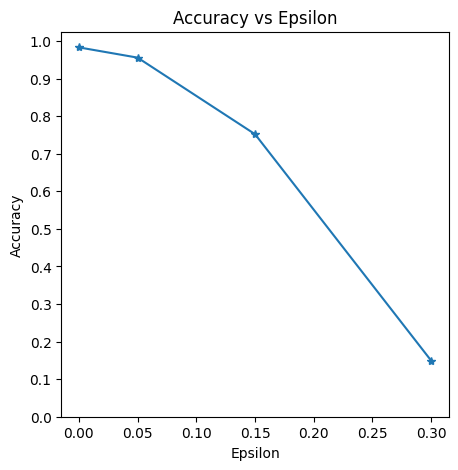

In [ ]:
epsilons = [0, .05, .15, .3]

accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test_untargeted_fgsm_attack(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

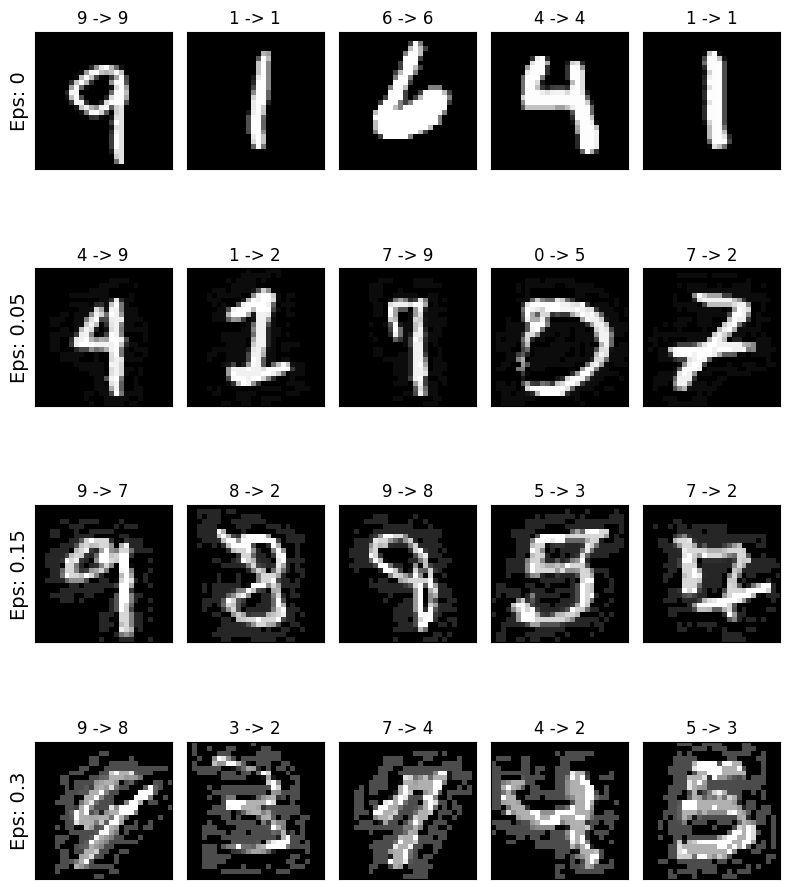

In [ ]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel(f"Eps: {epsilons[i]}", fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title(f"{orig} -> {adv}")
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

### Targeted FGSM

In [ ]:
def targeted_fgsm_attack(image, targeted, epsilon, data_grad):
    sign_data_grad = data_grad.sign()

    if targeted:
      perturbed_image = image - epsilon*sign_data_grad
    else:
      perturbed_image = image + epsilon*sign_data_grad

    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

In [ ]:
def test_targeted_fgsm_attack(model, device, dataloader, targeted=False, epsilon=0.2, target_label=7):
     # Accuracy counter
    correct = 0
    total = 0
    target = 0

    for data, label in dataloader:
        if (data.shape[0] != 64):
            break
        data, label = data.to(device), label.to(device)
        data.requires_grad = True
        output = model(data)
        init_pred = output.argmax(1, keepdim=True) # get the index of the max log-probability

        if targeted:
          loss = F.cross_entropy(output, torch.tensor([target_label]*64).to(device))
        else:
          loss = F.cross_entropy(output, label)

        model.zero_grad()
        loss.backward()
        data_grad = data.grad.data
        data_denorm = denormalize(data)
        perturbed_data = targeted_fgsm_attack(data_denorm, targeted, epsilon, data_grad)
        perturbed_data_normalized = transforms.Normalize((0.1307,), (0.3081,))(perturbed_data)
        output = model(perturbed_data_normalized)

        # Check for success
        final_pred = output.argmax(1, keepdim=True) # get the index of the max log-probability
        for i in range(len(final_pred)):
            if final_pred[i] == label[i]:
                correct+=1
            if final_pred[i] == target_label:
                target+=1
            total += 1

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(total)
    print(f"Epsilon: {epsilon}\tTest Accuracy = {correct} / {total} = {final_acc}\tTarget Score = {target}/{total}")

    # Return the accuracy and an adversarial example
    return final_acc


Epsilon: 0	Test Accuracy = 9816 / 9984 = 0.9831730769230769	Target Score = 1025/9984
Epsilon: 0.05	Test Accuracy = 9760 / 9984 = 0.9775641025641025	Target Score = 1077/9984
Epsilon: 0.15	Test Accuracy = 8612 / 9984 = 0.8625801282051282	Target Score = 1452/9984
Epsilon: 0.3	Test Accuracy = 2614 / 9984 = 0.26181891025641024	Target Score = 1870/9984


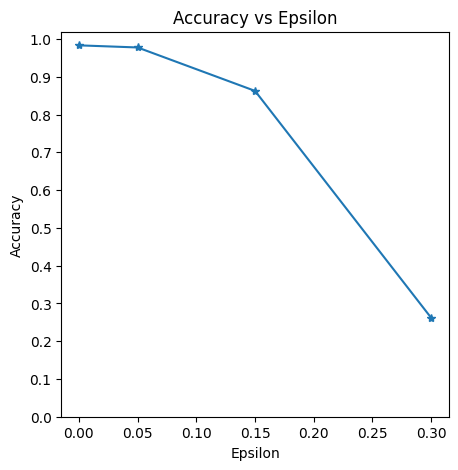

In [ ]:
accuracies = []

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,)),
            ])),
        batch_size=64, shuffle=True)

# Run test for each epsilon
for eps in epsilons:
    acc = test_targeted_fgsm_attack(model, device, test_loader, True, eps)
    accuracies.append(acc)

plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

Accuracy always decreases with the increase of the epsilon value, but it also makes the perturbation more perceptible. Hence, it may not always be the best choice to use the highest epsilon value.

At epsilons of 0.3, it seems to become very perceptible to humans.

## PGD Attack

In [ ]:
def untargeted_pgd_attack(image, data_grad, num_iter, alpha=0.01, epsilon=0.2):
    perturbed_image = image.clone().detach()

    for _ in range(num_iter):
        with torch.no_grad():
            perturbed_image += alpha * data_grad.sign()
            perturbed_image = torch.max(torch.min(perturbed_image, image + epsilon), image - epsilon)
            perturbed_image = torch.clamp(perturbed_image, 0, 1)

    return perturbed_image

Epsilon: 0	Test Accuracy = 9832 / 10000 = 0.9832
Epsilon: 0.05	Test Accuracy = 9559 / 10000 = 0.9559
Epsilon: 0.15	Test Accuracy = 7411 / 10000 = 0.7411
Epsilon: 0.3	Test Accuracy = 1172 / 10000 = 0.1172


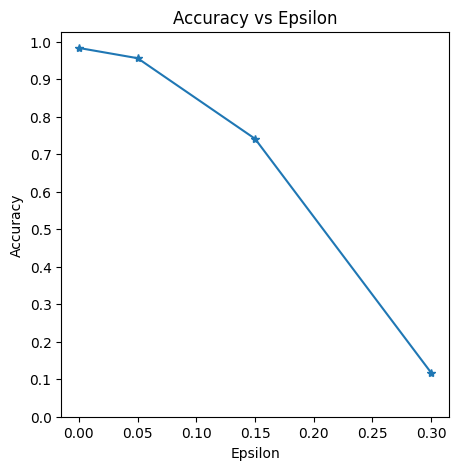

In [ ]:
def test_untargeted_pgd_attack(model, device, dataloader, epsilon=0.2, alpha=0.01, num_iter=40):
    correct = 0
    total = 0

    # Loop over all examples in test set
    for data, label in dataloader:
        data, label = data.to(device), label.to(device)
        data.requires_grad = True
        output = model(data)
        init_pred = output.argmax(1, keepdim=True) # get the index of the max log-probability
        loss = F.cross_entropy(output, label)
        model.zero_grad()
        loss.backward()
        data_grad = data.grad.data
        data_denorm = denormalize(data)

        perturbed_data = untargeted_pgd_attack(data_denorm, data_grad, num_iter, alpha, epsilon)
        perturbed_data_normalized = transforms.Normalize((0.1307,), (0.3081,))(perturbed_data)

        output = model(perturbed_data_normalized)

        # Check for success
        final_pred = output.argmax(1, keepdim=True) # get the index of the max log-probability
        # correct += final_pred.eq(label.view_as(final_pred)).sum().item()
        for i in range(len(final_pred)):
            if final_pred[i] == label[i]:
                correct+=1
            total += 1
        # total += len(label)

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(dataloader.dataset))
    print(f"Epsilon: {epsilon}\tTest Accuracy = {correct} / {len(dataloader.dataset)} = {final_acc}")

    # Return the accuracy and an adversarial example
    return final_acc


epsilons = [0, .05, .15, .3]
accuracies = []

# Run test for each epsilon
for eps in epsilons:
    acc = test_untargeted_pgd_attack(model, device, test_loader, eps)
    accuracies.append(acc)

plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

# Adversarial Training

### FGSM &mdash; Untargeted

In [ ]:
robust_fgsm_un_model = Net()
robust_fgsm_un_model = robust_fgsm_un_model.to(device)

optimizer = optim.SGD(robust_fgsm_un_model.parameters(), lr=0.01)
epoch_acc = []

correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = robust_fgsm_un_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
epoch_acc.append(accuracy)
print(f"Test Accuracy: {accuracy}%\n")

num_epochs = 10
for epoch in range(num_epochs):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        images.requires_grad = True
        outputs = robust_fgsm_un_model(images.to(device))
        loss = F.cross_entropy(outputs, labels.to(device))
        optimizer.zero_grad()
        loss.backward()
        images_grad = images.grad.data

        epsilon = 0.2
        images_adv = images + epsilon * images_grad.sign()
        images_adv = torch.clamp(images_adv, 0, 1)

        # Compute loss between predicted output on adversarial example and true label
        outputs_adv = robust_fgsm_un_model(images_adv.to(device))
        loss_adv = F.cross_entropy(outputs_adv, labels.to(device))

        optimizer.zero_grad()
        loss_adv.backward()
        optimizer.step()

    # Evaluate robust_fgsm_un_model's performance on testing dataloader
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = robust_fgsm_un_model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    epoch_acc.append(accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}] \t Test Accuracy: {accuracy}%")


Epoch [1/10] 	 Test Accuracy: 88.37%
Epoch [2/10] 	 Test Accuracy: 90.91%
Epoch [3/10] 	 Test Accuracy: 91.84%
Epoch [4/10] 	 Test Accuracy: 93.1%
Epoch [5/10] 	 Test Accuracy: 93.12%
Epoch [6/10] 	 Test Accuracy: 94.14%
Epoch [7/10] 	 Test Accuracy: 94.44%
Epoch [8/10] 	 Test Accuracy: 94.75%
Epoch [9/10] 	 Test Accuracy: 95.24%
Epoch [10/10] 	 Test Accuracy: 95.78%


In [ ]:
test_untargeted_fgsm_attack(robust_fgsm_un_model, device, test_loader, 0.2)

Epsilon: 0.2	Test Accuracy = 7135 / 10000 = 0.7135


0.7135

In [ ]:
test_untargeted_fgsm_attack(model, device, test_loader, 0.2)

Epsilon: 0.2	Test Accuracy = 5070 / 10000 = 0.507


0.507

## PGD &mdash; Untargeted

In [ ]:
robust_pgd_untargeted_model = Net()
robust_pgd_untargeted_model = robust_pgd_untargeted_model.to(device)

optimizer = optim.SGD(robust_pgd_untargeted_model.parameters(), lr=0.01)
epoch_acc = []

correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = robust_pgd_untargeted_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
epoch_acc.append(accuracy)
print(f"Test Accuracy: {accuracy}%\n")

num_epochs = 10
for epoch in range(num_epochs):
    for images, labels in train_loader:
        if (images.shape[0] != 64):
            break
        images, labels = images.to(device), labels.to(device)
        images.requires_grad = True
        outputs = robust_pgd_untargeted_model(images.to(device))
        loss = F.cross_entropy(outputs, labels.to(device))
        optimizer.zero_grad()
        loss.backward()
        images_grad = images.grad.data

        epsilon = 0.2
        images_adv = untargeted_pgd_attack(images, images_grad, 40, 0.01, 0.2)

        # Compute loss between predicted output on adversarial example and target label
        outputs_adv = robust_pgd_untargeted_model(images_adv.to(device))
        loss_adv = F.cross_entropy(outputs_adv, labels.to(device))

        optimizer.zero_grad()
        loss_adv.backward()
        optimizer.step()

    # Evaluate robust_pgd_untargeted_model's performance on testing dataloader
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = robust_pgd_untargeted_model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    epoch_acc.append(accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}] \t Test Accuracy: {accuracy}%")

Test Accuracy: 7.46%

Epoch [1/10] 	 Test Accuracy: 88.8%
Epoch [2/10] 	 Test Accuracy: 91.5%
Epoch [3/10] 	 Test Accuracy: 92.23%
Epoch [4/10] 	 Test Accuracy: 92.59%
Epoch [5/10] 	 Test Accuracy: 93.8%
Epoch [6/10] 	 Test Accuracy: 94.21%
Epoch [7/10] 	 Test Accuracy: 94.28%
Epoch [8/10] 	 Test Accuracy: 94.93%
Epoch [9/10] 	 Test Accuracy: 95.42%
Epoch [10/10] 	 Test Accuracy: 95.75%


In [ ]:
test_untargeted_pgd_attack(robust_pgd_untargeted_model, device, test_loader)

Epsilon: 0.2	Test Accuracy = 6879 / 10000 = 0.6879


0.6879

In [ ]:
test_untargeted_pgd_attack(model, device, test_loader)

Epsilon: 0.2	Test Accuracy = 5070 / 10000 = 0.507


0.507

# Text Based attacks

- https://github.com/QData/TextAttack
- LLM Attacks: https://llm-attacks.org/

- Download text attack and explore the methods  
- Pick an example and augment it in few ways (2+)
- Download the bert model, and use it for attack

# Inconsistency - SaGE

- https://aclanthology.org/2024.lrec-main.1243/
